In [1]:
import glob
from IPython.display import Audio
import matplotlib.pyplot as plt
import os

import numpy as np
import librosa

import torch
import sys

sys.path.append('/home/jupyter/rfcx/s3prl/transformer/')
sys.path.append('/home/jupyter/rfcx/s3prl/')
sys.path.append('/home/jupyter/rfcx_submission/scripts')

from model import TransformerModel , TransformerForMaskedAcousticModel , TransformerConfig
import transformer
import load_mel

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [2]:
from functools import lru_cache


In [3]:
# Preprocesser

In [4]:
class Preprocessor:
    def __init__(self, hidden_size, dr, device):
        self.hidden_size = hidden_size
        self.device = device
        self.dr= dr

    def down_sample_frames(self, spec):
        left_over = spec.shape[1] % self.dr
        if left_over != 0: spec = spec[:, :-left_over, :]
        spec_stacked = spec.view(spec.shape[0], spec.shape[1]//self.dr, spec.shape[2]*self.dr)
        return spec_stacked

    @staticmethod
    @lru_cache(maxsize=128)
    def get_sinusoid_table(seq_len,hidden_size):
        def cal_angle(position, hid_idx):
            return position / np.power(10000, 2 * (hid_idx // 2) / hidden_size)

        def get_posi_angle_vec(position):
            return [cal_angle(position, hid_j) for hid_j in range(hidden_size)]

        sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(seq_len)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
        return torch.FloatTensor(sinusoid_table)

    @staticmethod
    def fast_position_encoding(seq_len,hidden_size, batch_size=None):
        ''' position encoding table '''
        table = Preprocessor.get_sinusoid_table(seq_len,hidden_size)

        if batch_size is not None:
            # using expand will not cause extra CPU memory allocation issue
            # however, the expanded tensor after put into GPU still need
            # GPU memory of expanded size, which should be avoided when
            # positional table is large
            # this path is not recommended
            batch_table = table.expand(batch_size, -1, -1)
            return batch_table # (batch_size, seq_len, hidden_size)
        else:
            # this path is most recommended, no extra CPU and GPU memory allocation
            # after getting the (seq_len, hidden_size) tensor, one should first put
            # this tensor into GPU then expand it
            return table  # (seq_len, hidden_size)


    def process_MAM_data(self, spec):
            """Process testing data for the masked acoustic model"""

            # Hack bucket if spec is loaded from the dataloader
            if len(spec.shape) == 4: # Bucketing should cause acoustic feature to have shape 1xBxTxD
                spec = spec.squeeze(0)
            # add arbitary batch axis B if input `spec` has shape of TxD
            elif len(spec.shape) == 2:
                spec = spec.unsqueeze(0)
            # input `spec` should have shape BxTxD
            elif len(spec.shape) != 3:
                raise ValueError('Input argument `spec` has invalid shape: {}'.format(spec.shape))

            # Down sample
            spec_stacked = self.down_sample_frames(spec) # (batch_size, seq_len, mel_dim * dr)

            # Record length for each uttr
            spec_len = np.sum(np.sum(spec_stacked.data.numpy(), axis=-1) != 0, axis=-1)
            spec_len = [int(sl) for sl in spec_len]

            batch_size = spec_stacked.shape[0]
            seq_len = spec_stacked.shape[1]

            pos_enc = Preprocessor.fast_position_encoding(seq_len,self.hidden_size)
            attn_mask = np.ones((batch_size, seq_len)) # (batch_size, seq_len)

            # zero vectors for padding dimension
            for idx in range(len(spec_stacked)):
                attn_mask[idx][spec_len[idx]:] = 0 

            spec_stacked = spec_stacked.to(device=self.device, dtype=torch.float32)
            pos_enc = torch.FloatTensor(pos_enc).to(device=self.device, dtype=torch.float32).expand(spec_stacked.size(0), *pos_enc.size())
            attn_mask = torch.FloatTensor(attn_mask).to(device=self.device, dtype=torch.float32)
            return spec_stacked, pos_enc, attn_mask # (x, pos_enc, attention_mask)

## Load Model

In [5]:
def load_model(ckpt_path,device='cpu'):


    ckpt = torch.load(ckpt_path, map_location='cpu')

    weights = ckpt['Transformer']
    config = ckpt['Settings']['Config']

    # print(ckpt.keys())


    model_config = TransformerConfig(config)
    input_dim = config['transformer']['input_dim']
    dr= model_config.downsample_rate
    hidden_size = model_config.hidden_size

    output_attention= False
    device= device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    output_dim = input_dim

    model = TransformerForMaskedAcousticModel(model_config,
                                                    input_dim,
                                                    output_dim = output_dim,
                                                    output_attentions=output_attention
                                                   ).to(device)
    
    model.Transformer.load_state_dict(ckpt['Transformer'])
    model.SpecHead.load_state_dict(ckpt['SpecHead'])

    model.eval()
    return model, hidden_size, dr, device



In [6]:
class CustomTransformerModel(torch.nn.Module):
  
    def __init__(self, transformer_model: TransformerForMaskedAcousticModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        self.maxlen=3000
    
    def split(self,inp):
        #shape of each input is (batch_size, sequence, mel_features)
        #goal is to split the sequence if the sequence length is greater tha maxlen
        sequence_length = inp.shape[1]
        axes_length= len(inp.shape)
        
        if sequence_length> self.maxlen:
            
            sub_sequences= []
            num_subseq= sequence_length//self.maxlen
            start= 0
            
            for i in range(1,num_subseq+1):
                end= self.maxlen*i
                if axes_length==2:
                    sub_sequences.append(inp[:, start:end])
                else:
                    sub_sequences.append(inp[:, start:end, :])
                
                start=end
                
            if end<sequence_length:
                if axes_length==2:
                    sub_sequences.append(inp[:, start:])
                else:
                    sub_sequences.append(inp[:, start:, :])
        
            return sub_sequences
        else:
            return [inp]
            
        
    def forward(self, spec, pos_enc, attn_mask):
                
        split_spec= self.split(spec)
        split_pos_enc= self.split(pos_enc)
        split_attn_mask= self.split(attn_mask)
        
        pred_spec = []
        
        for a,b,c in zip(split_spec, split_pos_enc, split_attn_mask) :
            
            _pred_spec, _ = self.transformer(spec_input=a,
                                        pos_enc=b,
                                        mask_label=None,
                                        attention_mask=c,
                                        spec_label=None,
                                        head_mask=None)
            
            pred_spec.append(_pred_spec)
            
        pred_spec= torch.cat(pred_spec, axis=1)
        return pred_spec

In [129]:
# ckpt_path= '/home/jupyter/rfcx/rfcx/model_weights/pretrained_model/states-1000000.ckpt'

ckpt_path= '/home/jupyter/rfcx/rfcx/model_weights/mockingjay_mel80_no_delta_cmvn_run4/states-2000.ckpt'
# ckpt_path= '/home/jupyter/rfcx/rfcx/model_weights/mockingjay_mel80_no_delta_cmvn_run3/states-3000.ckpt'



model , hidden_size, dr, device = load_model(ckpt_path)

In [130]:
preprocessor= Preprocessor(hidden_size, dr, device)
custom_model = CustomTransformerModel(model)

In [131]:
audio_files= glob.glob('/home/jupyter/rfcx/data/*/*.flac')
# audio_files= glob.glob('/home/jupyter/librispeech/LibriSpeech/test-other/1688/142285/*.flac')
len(audio_files)

6719

In [132]:
input_file= audio_files[-50]
input_file

'/home/jupyter/rfcx/data/test/8aaf74b7a.flac'

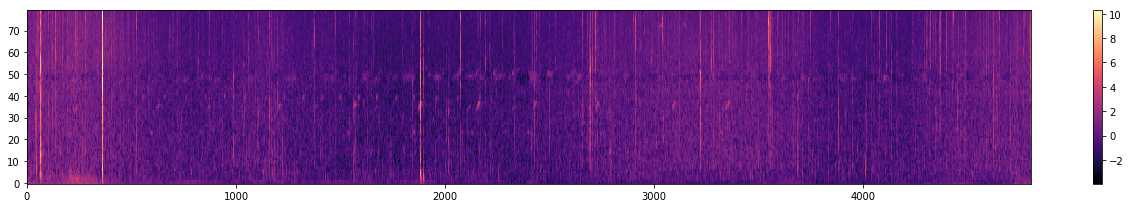

In [133]:
sample_rate=32000
y,sr= load_mel.load_audio(input_file, sample_rate)
feat= load_mel.get_spectrogram(y,sr,apply_denoise=False,return_audio=False)

load_mel.plot_feature(feat)

In [134]:

spec= torch.tensor(feat)
spec= spec.permute(1, 0)
spec_stacked, pos_enc, attn_mask = preprocessor.process_MAM_data(spec=spec)


In [135]:
spec_stacked.shape, pos_enc.shape, attn_mask.shape

(torch.Size([1, 4801, 80]), torch.Size([1, 4801, 768]), torch.Size([1, 4801]))

In [136]:
pred_spec= custom_model(spec_stacked, pos_enc, attn_mask)
pred_spec.shape

torch.Size([1, 4801, 80])

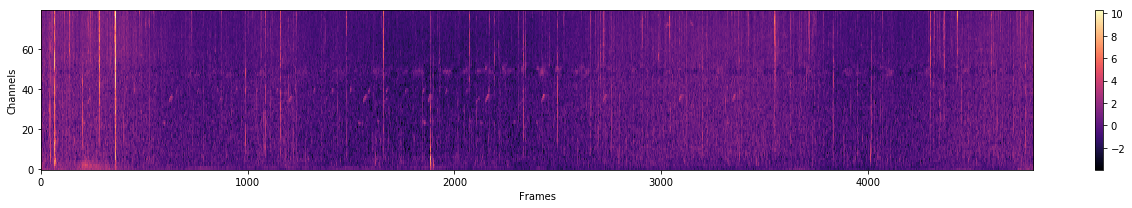

In [119]:
plot_spectrogram_to_numpy(spec_stacked.detach().numpy().squeeze())

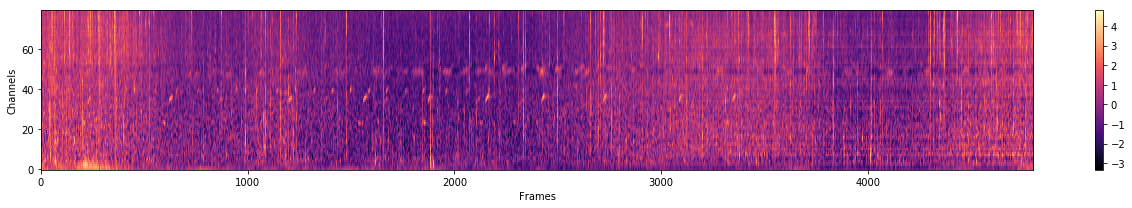

In [137]:
plot_spectrogram_to_numpy(pred_spec.detach().numpy().squeeze())

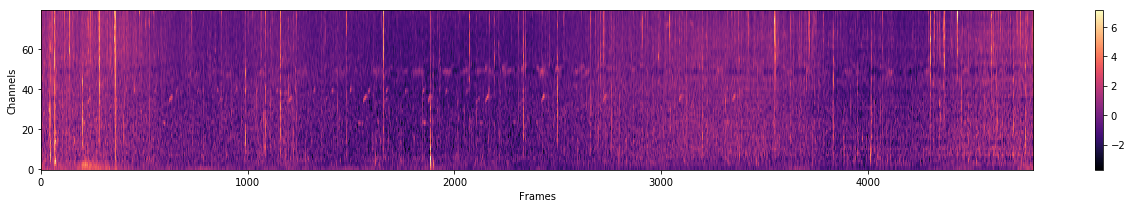

In [128]:
plot_spectrogram_to_numpy(pred_spec.detach().numpy().squeeze())

In [15]:
def plot_spectrogram_to_numpy(spectrogram):
    spectrogram = spectrogram.transpose(1, 0)
    fig, ax = plt.subplots(figsize=(18, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",cmap='magma')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.tight_layout()

    fig.canvas.draw()
